Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
# url = 'http://yaroslavvb.com/upload/notMNIST/'

# def maybe_download(filename, expected_bytes):
#   """Download a file if not present, and make sure it's the right size."""
#   if not os.path.exists(filename):
#     filename, _ = urlretrieve(url + filename, filename)
#   statinfo = os.stat(filename)
#   if statinfo.st_size == expected_bytes:
#     print 'Found and verified', filename
#   else:
#     raise Exception(
#       'Failed to verify' + filename + '. Can you get to it with a browser?')
#   return filename

# train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
# test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
# num_classes = 10

# def extract(filename):
#   tar = tarfile.open(filename)
#   root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
#   print('Extracting data for %s. This may take a while. Please wait.' % root)
#   sys.stdout.flush()
#   tar.extractall()
#   tar.close()
#   data_folders = [
#     os.path.join(root, d) for d in sorted(os.listdir(root)) if d != '.DS_Store']
#   if len(data_folders) != num_classes:
#     raise Exception(
#       'Expected %d folders, one per class. Found %d instead.' % (
#         num_classes, len(data_folders)))
#   print(data_folders)
#   return data_folders
#train_folders = extract(train_filename)
#test_folders = extract(test_filename)

In [4]:
from string import ascii_uppercase
test_folders = ['notMNIST_small/{0}'.format(i) for i in ascii_uppercase[:10]]
train_folders = ['notMNIST_large/{0}'.format(i) for i in ascii_uppercase[:10]]

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
from IPython.display import Image

fn = test_folders[0] + '/' + os.listdir(test_folders[0])[0]
Image(filename=fn)

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):

    dataset = np.ndarray(shape=(max_num_images, image_size, image_size), dtype=np.float32)
    labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
    label_index = 0
    image_index = 0
    for folder in data_folders:
        print(folder)
        for image in os.listdir(folder):
            if image_index >= max_num_images:
                raise Exception('More images than expected: %d >= %d' % (image_index, max_num_images))
            image_file = os.path.join(folder, image)
            try:
                image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
                if image_data.shape != (image_size, image_size):
                    raise Exception('Unexpected image shape: %s' % str(image_data.shape))
                dataset[image_index, :, :] = image_data
                labels[image_index] = label_index
                image_index += 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
        label_index += 1
    num_images = image_index
    dataset = dataset[0:num_images, :, :]
    labels = labels[0:num_images]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    print('Labels:', labels.shape)
        
    return dataset, labels

In [8]:
test_dataset, test_labels = load(test_folders, 18000, 20000)
np.save('cache/test_dataset.npy', test_dataset)
np.save('cache/test_labels.npy', test_labels)

notMNIST_small/A
('Could not read:', 'notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_small/B
notMNIST_small/C
notMNIST_small/D
notMNIST_small/E
notMNIST_small/F
('Could not read:', 'notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_small/G
notMNIST_small/H
notMNIST_small/I
notMNIST_small/J
('Full dataset tensor:', (18724, 28, 28))
('Mean:', -0.074784115)
('Standard deviation:', 0.45428821)
('Labels:', (18724,))


In [9]:
train_dataset, train_labels = load(train_folders, 450000, 550000)
np.save('cache/train_dataset.npy', train_dataset)
np.save('cache/train_labels.npy', train_labels)

notMNIST_large/A
('Could not read:', 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
('Could not read:', 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/B
('Could not read:', 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/C
notMNIST_large/D
('Could not read:', 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png', ':', IOError('cannot identify image file',), "- it's ok, skipping.")
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H
notMNIST_large/I
notMNIST_large/J
('Full dataset tensor:', (529114, 28, 28))
('Mean:', -0.020221984)
('Standard deviation:', 0.14220417)
('Lab

In [ ]:
# test_dataset = np.load('cache/test_dataset.npy')
# test_labels = np.load('cache/test_labels.npy')
# train_dataset = np.load('cache/train_dataset.npy')
# train_labels = np.load('cache/train_labels.npy')

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

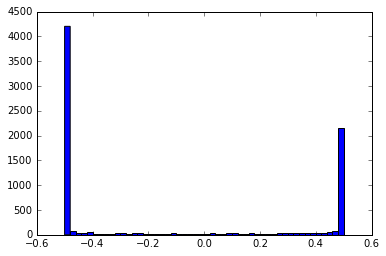

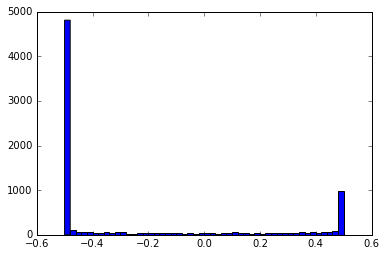

In [10]:
x = test_dataset[:10,:,:].flatten()
n, bins, patches = plt.hist(x, 50,)
plt.show()

x = train_dataset[:10,:,:].flatten()
n, bins, patches = plt.hist(x, 50,)
plt.show()

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
np.random.seed(133)
def randomize_index(count):
    permutation = np.random.permutation(count)
    return permutation

In [12]:
index = randomize_index(train_dataset.shape[0])
train_dataset = train_dataset[index,:,:]
train_labels = train_labels[index]

In [13]:
index = randomize_index(test_dataset.shape[0])
test_dataset = test_dataset[index,:,:]
test_labels = test_labels[index]

In [16]:
np.save('cache/train_dataset_shuffled.npy', train_dataset)
np.save('cache/train_labels_shuffled.npy', train_labels)
np.save('cache/test_dataset_shuffled.npy', test_dataset)
np.save('cache/test_labels_shuffled.npy', test_labels)

In [3]:
test_dataset = np.load('cache/test_dataset_shuffled.npy')
test_labels = np.load('cache/test_labels_shuffled.npy')
train_dataset = np.load('cache/train_dataset_shuffled.npy')
train_labels = np.load('cache/train_labels_shuffled.npy')

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

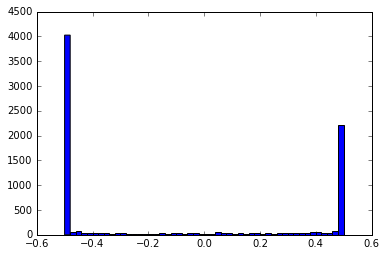

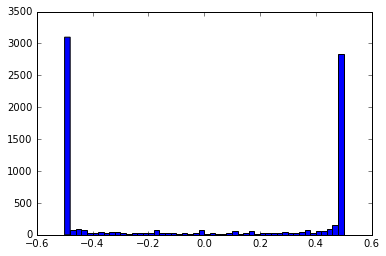

In [14]:
x = test_dataset[:10,:,:].flatten()
n, bins, patches = plt.hist(x, 50,)
plt.show()

x = train_dataset[:10,:,:].flatten()
n, bins, patches = plt.hist(x, 50,)
plt.show()

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

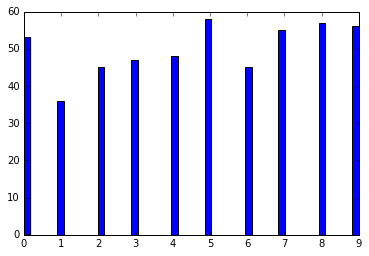

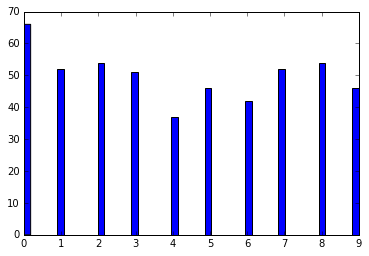

In [15]:
x = test_labels[:500]
n, bins, patches = plt.hist(x, 50,)
plt.show()

x = train_labels[:500]
n, bins, patches = plt.hist(x, 50,)
plt.show()

Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [4]:
#train_size = 200000
valid_size = 10000

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:,:,:]
train_labels = train_labels[valid_size:]
print('Training', train_dataset.shape, train_labels.shape)
print('Validation', valid_dataset.shape, valid_labels.shape)

('Training', (519114, 28, 28), (519114,))
('Validation', (10000, 28, 28), (10000,))


Finally, let's save the data for later reuse:

In [5]:
pickle_file = 'cache/notMNIST.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [6]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

('Compressed pickle size:', 1720211761)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [112]:
def flat_hash(dataset):
    flat_len = dataset.shape[1] * dataset.shape[2]
    dataset = dataset.reshape([dataset.shape[0], flat_len])
    rows = []
    full_len = dataset.shape[0]
    for i in range(full_len):
        row = dataset[i,:]
        row.flags.writeable = False
        row = hash(row.data)
        rows.append(row)
    return rows

In [113]:
test_dataset_hashed = np.unique(np.array(flat_hash(test_dataset)))
valid_dataset_hashed = np.unique(np.array(flat_hash(valid_dataset)))
train_dataset_hashed = np.unique(np.array(flat_hash(train_dataset)))

In [114]:
x = np.concatenate([train_dataset_hashed, test_dataset_hashed], axis=0)
print('train-test duplicates: {0}'.format(x.shape[0] - np.unique(x).shape[0]))

x = np.concatenate([train_dataset_hashed, valid_dataset_hashed], axis=0)
print('train-valid duplicates: {0}'.format(x.shape[0] - np.unique(x).shape[0]))

x = np.concatenate([valid_dataset_hashed, test_dataset_hashed], axis=0)
print('valid-test duplicates: {0}'.format(x.shape[0] - np.unique(x).shape[0]))

train-test duplicates: 2064
train-valid duplicates: 948
valid-test duplicates: 122


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [7]:
from sklearn.linear_model import SGDClassifier

def to_rows(dataset):
    flat_len = dataset.shape[1] * dataset.shape[2]
    dataset = dataset.reshape([dataset.shape[0], flat_len])
    return dataset

X = to_rows(train_dataset)
y = train_labels

classes = [c for c in range(10)]
interval = 500
scores = {}
for a in (.001, .01, .1, .5, 1.):
    print('alpha: {0}'.format(a))
    i = 1
    keep_going = True
    clf = SGDClassifier(loss="hinge", penalty="l2", alpha=.1)
    while keep_going:
        
        inds = [(i - 1) * interval, i * interval]
        
        if inds[1] > X.shape[0] - 1:
            inds[1] = X.shape[0] - 1
            keep_going = False
        
        if inds[1] % 100000 == 0:
            print('\t{0}'.format(inds))
        
        clf.partial_fit(X[inds], y[inds], classes)
        
        i += 1
        
    score = clf.score(to_rows(valid_dataset), valid_labels)
    scores[a] = score

scores

alpha: 0.001
	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]
alpha: 0.01
	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]
alpha: 0.1
	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]
alpha: 0.5
	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]
alpha: 1.0
	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]


{0.001: 0.75149999999999995,
 0.01: 0.74619999999999997,
 0.1: 0.75890000000000002,
 0.5: 0.74770000000000003,
 1.0: 0.75519999999999998}

In [10]:
print valid_labels
print clf.predict(to_rows(valid_dataset))

[7 7 6 ..., 1 8 9]
[7 7 9 ..., 0 5 9]


In [15]:
X = np.concatenate([to_rows(train_dataset), to_rows(valid_dataset)], axis=0)
y = np.concatenate([train_labels, valid_labels], axis=0)

interval = 500
i = 1
keep_going = True
clf = SGDClassifier(loss="hinge", penalty="l2", alpha=.1)
while keep_going:

    inds = [(i - 1) * interval, i * interval]

    if inds[1] > X.shape[0] - 1:
        inds[1] = X.shape[0] - 1
        keep_going = False

    if inds[1] % 100000 == 0:
        print('\t{0}'.format(inds))

    clf.partial_fit(X[inds], y[inds], classes)

    i += 1

clf.score(to_rows(test_dataset), test_labels)

	[99500, 100000]
	[199500, 200000]
	[299500, 300000]
	[399500, 400000]
	[499500, 500000]


0.79267250587481308

In [16]:
print test_labels
print clf.predict(to_rows(test_dataset))

[3 9 6 ..., 1 9 8]
[3 9 6 ..., 1 9 1]
